In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33865,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:55913,Total threads: 1
Dashboard: http://127.0.0.1:43202/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:47358,


In [4]:
from utils import Import_Expt_Front, date_fmt

In [5]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc')

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [14]:
# dataset_gridT_1d = EXF.import_multipe_expt('grid_T',vars_of_interest=['rhop'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':5,'x':251,'y':251})

In [16]:
# dataset_gridW_1d = EXF.import_multipe_expt('grid_W',vars_of_interest=['woce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':5,'x':251,'y':251})

In [17]:
rau0 = 1026.0
g = 9.81

In [18]:
r1_rau0     = 1.0 / rau0

In [19]:
buoyancy =  - g * (dataset_gridT_1d.rhop_006 * r1_rau0 - 1 )

In [20]:
output_folder= "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/postprocessed/"

In [21]:
# b_prime_mean = xr.open_dataset(output_folder+'mean_b_prime.nc')

In [22]:
# b_mean = buoyancy.mean("time_counter").compute()

In [23]:
# (b_prime_mean.rhop_006 - b_mean).isel(deptht=0,y=slice(2,-2)).plot()

In [24]:
# (b_prime_mean.rhop_006 - b_mean).sum('deptht').isel(y=slice(2,-2)).plot()

$b = -g(\rho-\rho_0 ) /\rho_0 $

CDFtools:

-g (  rho * r1_rau0 - 1._wp  )

In [25]:
mean_buoyancy = buoyancy.mean("x")

In [26]:
# seasonal_mean_buoyancy = mean_buoyancy.groupby("time_counter.season").mean().compute()

In [27]:
# fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=300)

# seasonal_mean_buoyancy.sel(season="DJF").plot(ax=ax[0],vmin=-2e-3,vmax=2e-3,cmap=cm.cm.balance)
# seasonal_mean_buoyancy.sel(season="MAM").plot(ax=ax[1],vmin=-2e-3,vmax=2e-3,cmap=cm.cm.balance)
# seasonal_mean_buoyancy.sel(season="JJA").plot(ax=ax[2],vmin=-2e-3,vmax=2e-3,cmap=cm.cm.balance)
# seasonal_mean_buoyancy.sel(season="SON").plot(ax=ax[3],vmin=-2e-3,vmax=2e-3,cmap=cm.cm.balance)

# ax[0].set_ylim(0,200)
# ax[1].set_ylim(0,200)
# ax[2].set_ylim(0,200)
# ax[3].set_ylim(0,200)

In [28]:
b_prime = buoyancy - mean_buoyancy

In [29]:
b_prime_mean = b_prime.mean("time_counter")

In [30]:
output_folder= "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/postprocessed/"

In [31]:
# b_prime_mean.to_netcdf(output_folder+'mean_b_prime_corrected.nc')

In [32]:
w = dataset_gridW_1d.woce_006

In [33]:
mean_w = w.mean("x")

(0.0, 200.0)

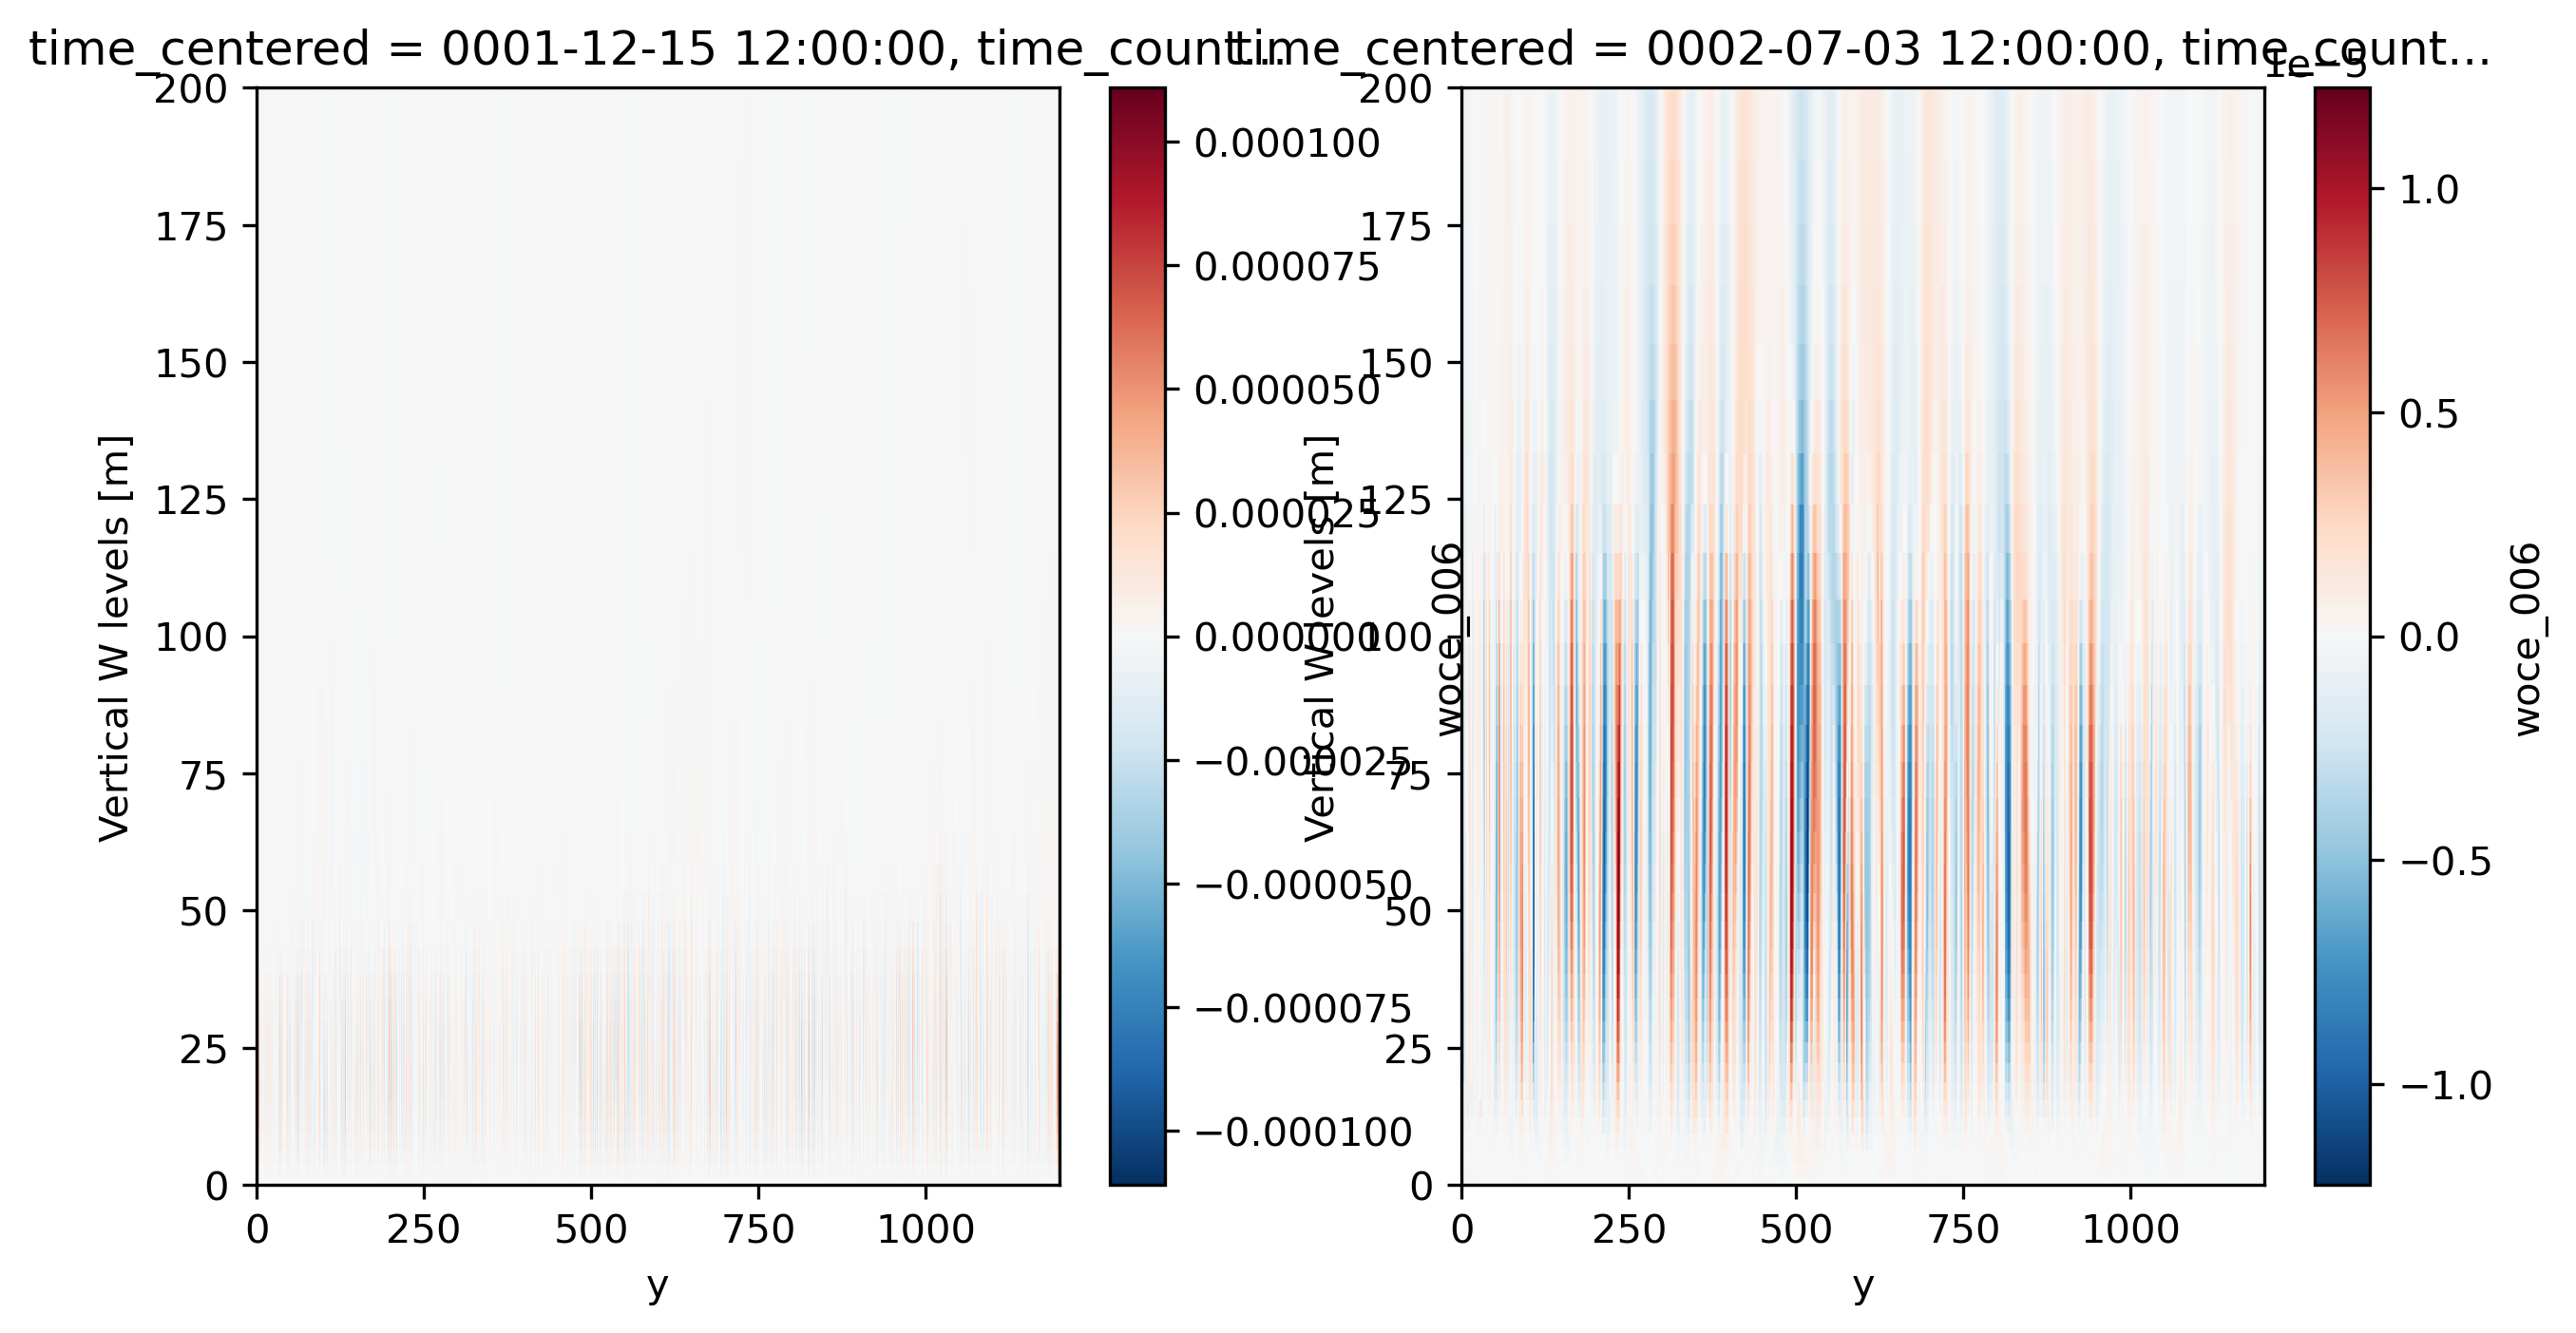

In [34]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=300)
mean_w.isel(time_counter=0).plot(ax=ax[0])
mean_w.isel(time_counter=200).plot(ax=ax[1])

ax[0].set_ylim(0,200)
ax[1].set_ylim(0,200)

In [35]:
w_prime = w - mean_w

In [36]:
# w_prime_mean = w_prime.mean("time_counter")

In [37]:
# w_prime_mean.to_netcdf(output_folder+'mean_w_prime.nc')

# Interpolate w

In [38]:
def interp_field(x):
    x_centered = (x + x.roll(depthw=1))/2
    return x_centered

In [39]:
b_prime_wgrid = b_prime.isel(deptht=slice(0,50))

In [40]:
w_prime_interp = interp_field(w_prime).isel(depthw=slice(0,50)).rename({"depthw":"deptht"})

In [41]:
w_prime_interp["deptht"] = b_prime_wgrid.deptht

# Compute w'b'

In [42]:
wpbp = (w_prime_interp*b_prime_wgrid).rename('wpbp')

In [43]:
wpbp_folder = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/postprocessed/wpbp/"

In [ ]:
counter=0
for time in wpbp.time_counter:
    str_time = str(time.values)[0:10]
    print(counter, str_time)
    snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))
    snap_wpbp.to_netcdf(wpbp_folder+"wpbp_corrected_{0}.nc".format(str_time.replace("-","_")))
    print("Stored")
    counter+=1

0 0001-12-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
1 0001-12-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
2 0001-12-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
3 0001-12-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
4 0001-12-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
5 0001-12-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
6 0001-12-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
7 0001-12-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
8 0001-12-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
9 0001-12-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
10 0001-12-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
11 0001-12-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
12 0001-12-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
13 0001-12-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
14 0001-12-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
15 0001-12-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
16 0001-12-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
17 0002-01-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
18 0002-01-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
19 0002-01-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
20 0002-01-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
21 0002-01-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
22 0002-01-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
23 0002-01-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
24 0002-01-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
25 0002-01-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
26 0002-01-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
27 0002-01-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
28 0002-01-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
29 0002-01-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
30 0002-01-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
31 0002-01-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
32 0002-01-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
33 0002-01-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
34 0002-01-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
35 0002-01-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
36 0002-01-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
37 0002-01-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
38 0002-01-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
39 0002-01-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
40 0002-01-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
41 0002-01-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
42 0002-01-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
43 0002-01-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
44 0002-01-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
45 0002-01-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
46 0002-01-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
47 0002-01-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
48 0002-02-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
49 0002-02-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
50 0002-02-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
51 0002-02-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
52 0002-02-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
53 0002-02-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
54 0002-02-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
55 0002-02-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
56 0002-02-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
57 0002-02-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
58 0002-02-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
59 0002-02-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
60 0002-02-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
61 0002-02-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
62 0002-02-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
63 0002-02-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
64 0002-02-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
65 0002-02-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
66 0002-02-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
67 0002-02-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
68 0002-02-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
69 0002-02-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
70 0002-02-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
71 0002-02-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
72 0002-02-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
73 0002-02-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
74 0002-02-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
75 0002-02-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
76 0002-03-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
77 0002-03-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
78 0002-03-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
79 0002-03-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
80 0002-03-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
81 0002-03-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
82 0002-03-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
83 0002-03-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
84 0002-03-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
85 0002-03-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
86 0002-03-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
87 0002-03-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
88 0002-03-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
89 0002-03-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
90 0002-03-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
91 0002-03-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
92 0002-03-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
93 0002-03-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
94 0002-03-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
95 0002-03-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
96 0002-03-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
97 0002-03-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
98 0002-03-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
99 0002-03-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
100 0002-03-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
101 0002-03-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
102 0002-03-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
103 0002-03-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
104 0002-03-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
105 0002-03-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
106 0002-03-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
121 0002-04-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
122 0002-04-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
123 0002-04-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
124 0002-04-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
125 0002-04-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
126 0002-04-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
127 0002-04-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
128 0002-04-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
129 0002-04-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
130 0002-04-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
131 0002-04-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
132 0002-04-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
133 0002-04-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
134 0002-04-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
135 0002-04-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
136 0002-04-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
137 0002-05-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
138 0002-05-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
139 0002-05-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
140 0002-05-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
141 0002-05-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
142 0002-05-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
143 0002-05-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
144 0002-05-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
145 0002-05-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
146 0002-05-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
147 0002-05-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
148 0002-05-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
149 0002-05-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
150 0002-05-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
151 0002-05-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
152 0002-05-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
153 0002-05-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
154 0002-05-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
155 0002-05-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
156 0002-05-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
157 0002-05-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
158 0002-05-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
159 0002-05-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
160 0002-05-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
161 0002-05-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
162 0002-05-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
163 0002-05-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
164 0002-05-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
165 0002-05-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
166 0002-05-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
167 0002-05-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
168 0002-06-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
169 0002-06-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
170 0002-06-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
171 0002-06-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
172 0002-06-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
173 0002-06-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
174 0002-06-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
175 0002-06-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
176 0002-06-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
177 0002-06-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
178 0002-06-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
179 0002-06-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
180 0002-06-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
181 0002-06-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
182 0002-06-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
183 0002-06-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
184 0002-06-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
185 0002-06-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
186 0002-06-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
187 0002-06-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
188 0002-06-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
189 0002-06-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
190 0002-06-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
191 0002-06-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
192 0002-06-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
193 0002-06-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
194 0002-06-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
195 0002-06-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
196 0002-06-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
197 0002-06-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
198 0002-07-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
199 0002-07-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
200 0002-07-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
201 0002-07-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
202 0002-07-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
203 0002-07-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
204 0002-07-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
205 0002-07-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
206 0002-07-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
207 0002-07-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
208 0002-07-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
209 0002-07-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
210 0002-07-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
211 0002-07-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
212 0002-07-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
213 0002-07-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
214 0002-07-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
215 0002-07-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
216 0002-07-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
217 0002-07-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
218 0002-07-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
219 0002-07-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
220 0002-07-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
221 0002-07-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
222 0002-07-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
223 0002-07-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
224 0002-07-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
225 0002-07-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
226 0002-07-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
227 0002-07-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
228 0002-07-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
229 0002-08-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
230 0002-08-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
231 0002-08-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
232 0002-08-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
233 0002-08-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
234 0002-08-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
235 0002-08-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
236 0002-08-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
237 0002-08-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
238 0002-08-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
239 0002-08-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
240 0002-08-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
241 0002-08-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
242 0002-08-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
243 0002-08-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
244 0002-08-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
245 0002-08-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
246 0002-08-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
247 0002-08-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
248 0002-08-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
249 0002-08-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
250 0002-08-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
251 0002-08-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
252 0002-08-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
253 0002-08-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
254 0002-08-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
255 0002-08-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
256 0002-08-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
257 0002-08-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
258 0002-08-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
259 0002-08-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
260 0002-09-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
261 0002-09-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
262 0002-09-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
263 0002-09-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
264 0002-09-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
265 0002-09-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
266 0002-09-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
267 0002-09-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
268 0002-09-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
269 0002-09-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
270 0002-09-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
271 0002-09-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
272 0002-09-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
273 0002-09-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
274 0002-09-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
275 0002-09-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
276 0002-09-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
277 0002-09-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
278 0002-09-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
279 0002-09-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
280 0002-09-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
281 0002-09-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
282 0002-09-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
283 0002-09-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
284 0002-09-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
285 0002-09-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
286 0002-09-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
287 0002-09-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
288 0002-09-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
289 0002-09-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
290 0002-10-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
291 0002-10-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
292 0002-10-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
293 0002-10-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
294 0002-10-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
295 0002-10-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
296 0002-10-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
297 0002-10-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
298 0002-10-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
299 0002-10-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
300 0002-10-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
301 0002-10-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
302 0002-10-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
303 0002-10-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
304 0002-10-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
305 0002-10-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
306 0002-10-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
307 0002-10-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
308 0002-10-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
309 0002-10-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
310 0002-10-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
311 0002-10-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
312 0002-10-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
313 0002-10-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
314 0002-10-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
315 0002-10-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
316 0002-10-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
317 0002-10-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
318 0002-10-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
319 0002-10-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
320 0002-10-31


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
321 0002-11-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
322 0002-11-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
323 0002-11-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
324 0002-11-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
325 0002-11-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
326 0002-11-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
327 0002-11-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
328 0002-11-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
329 0002-11-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
330 0002-11-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
331 0002-11-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
332 0002-11-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
333 0002-11-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
334 0002-11-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
335 0002-11-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
336 0002-11-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
337 0002-11-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
338 0002-11-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
339 0002-11-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
340 0002-11-20


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
341 0002-11-21


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
342 0002-11-22


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
343 0002-11-23


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
344 0002-11-24


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
345 0002-11-25


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
346 0002-11-26


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
347 0002-11-27


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
348 0002-11-28


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
349 0002-11-29


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
350 0002-11-30


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
351 0002-12-01


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
352 0002-12-02


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
353 0002-12-03


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
354 0002-12-04


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
355 0002-12-05


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
356 0002-12-06


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
357 0002-12-07


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
358 0002-12-08


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
359 0002-12-09


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
360 0002-12-10


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
361 0002-12-11


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
362 0002-12-12


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
363 0002-12-13


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
364 0002-12-14


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
365 0002-12-15


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
366 0002-12-16


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
367 0002-12-17


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
368 0002-12-18


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))


Stored
369 0002-12-19


/dev/shm/pbs.2915978.datarmor0/ipykernel_14604/2749567160.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  snap_wpbp = wpbp.sel(time_counter=time).drop(("time_centered","nav_lon","nav_lat"))
